## This program is made to track the rigid body variablity across the experimental protocol

In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.insert(0,'/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces')

# Set the save game location
# Must have format of "../PointerExperimentData/Name_dd_mm__hh_mm_metadata" with no file extension
# saveFile = "../PointerExperimentData/Ashwin_13_02"
# saveGameLocation = saveFile + "/Ash_13_02_13_19" # must have format of "Name_dd_mm__hh_mm_metadata" with no file extension

from Experiment_pointer.runFullExperiment import saveDirectory, saveGameLocation

saveFile = saveDirectory

# Replace Experiment pointer with .. as notebook runs from another directory
saveFile = saveFile.replace("Experiment_pointer","..")
saveGameLocation = saveGameLocation.replace("Experiment_pointer","..")
path = "/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces/Experiment_pointer/DataAnalysis"
os.chdir(path)

from Experiment_pointer.experimentFunctions import processTrialData
DOFOffset = 0.03
from sklearn.decomposition import PCA
from lib_streamAndRenderDataWorkflows.config_streaming import bodyParts


pygame 2.5.2 (SDL 2.28.3, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Fetch all trial information


rigidBodies1, cursorPos1,cursorVel1,goCues1,targetHits1,timeStamps1, minDof1,maxDof1,d = processTrialData(saveGameLocation + "_training1",DOFOffset)
rigidBodies2, cursorPos2,cursorVel2,goCues2,targetHits2,timeStamps2, minDof2,maxDof2,e = processTrialData(saveGameLocation + "_training2",DOFOffset)
rigidBodies3, cursorPos3,cursorVel3,goCues3,targetHits3,timeStamps3, minDof3,maxDof3,f = processTrialData(saveGameLocation + "_training3",DOFOffset)
rigidBodies4, cursorPos4,cursorVel4,goCues4,targetHits4,timeStamps4, minDof4,maxDof4,g = processTrialData(saveGameLocation + "_training4",DOFOffset)
rigidBodies5, cursorPos5,cursorVel5,goCues5,targetHits5,timeStamps5, minDof5,maxDof5,h = processTrialData(saveGameLocation + "_test",DOFOffset)# make this test 

In [3]:


def extractPCAFromRigidBodies(rigidBodyVector,cursorPos,useCursor = False):
    """
    Function that performs pca on each rigid body in rigid body vector to extract out main variations of each rigid body during trial
    """
    dimensionalityReducedRigidBodyVector = np.zeros((rigidBodyVector.shape[0],38))
    for rigidBodyIdx in range(0,19):

        
        # Retrieve current rigid body vector
        idxStart = rigidBodyIdx * 6
        idxEnd = idxStart + 6
        currRigidBody = rigidBodyVector[:,idxStart:idxEnd]
        rigidBodyPCA = PCA(n_components=2)
        X_new = rigidBodyPCA.fit_transform(currRigidBody)
        vars = rigidBodyPCA.explained_variance_ratio_
        if len(vars) == 2:
            print("Rigid Body: {}, variance explained in PC1: {}, and in PC2: {}".format(bodyParts[rigidBodyIdx],vars[0],vars[1]))
        elif len(vars) == 3:
            print("Rigid Body: {}, variance explained in PC1: {}, and in PC2: {} , and in PC3: {}".format(bodyParts[rigidBodyIdx],vars[0],vars[1],vars[2]))
        
        dimensionalityReducedRigidBodyVector[:,rigidBodyIdx*2:rigidBodyIdx*2+2] = X_new
        
    # Find the correlation coefficients between the right hand and other rigid odies
    bodiesCorrelationCoefficients = calcCorrelationCoefficients(dimensionalityReducedRigidBodyVector,cursorPos,useCursor = useCursor)


    outputDict = {
        "pca2RigidBodies" : dimensionalityReducedRigidBodyVector,
        "rigidBodiesCorrCoeffs" : bodiesCorrelationCoefficients

    }

    return outputDict


def calcCorrelationCoefficients(dimensionalityReducedRigidBodyVector,cursorPos,useCursor):

    """
    Calculates the correlation coefficients of the pca components
    """

    # Fetch Right hand principal component
    if not useCursor:
        rightHandPrincipalComponent = dimensionalityReducedRigidBodyVector[:,findBodyPart("RHand")[0]]
    else:
        print("Using cursor Position instead")
        rightHandPrincipalComponent = cursorPos[:,1]

    pearsonCoeffs = np.zeros(len(bodyParts))



    for idx,bodyPart in enumerate(bodyParts):
        # Fetch body part principal component
        bodyPartPrincipalComponent = dimensionalityReducedRigidBodyVector[:, findBodyPart(bodyPart)[0]]

        # Calculate correlation coefficient
        corrCoeff = np.corrcoef(rightHandPrincipalComponent,bodyPartPrincipalComponent)
        pearsonCoeffs[idx] = corrCoeff[0,1]

    return pearsonCoeffs

def findBodyPart(bodyPart):
    idx = bodyParts.index(bodyPart)
    return [idx, idx + 2]

def plotCorrelationCoefficientVariationAcrossTrial(rigidBodies,cursorPos,noRigidBodies = 19,discretisations = 10, trial = "1"):
    correlationCoefficientsInTrial = np.zeros((noRigidBodies,discretisations))
    totalLength = cursorPos.shape[0]
    sectionLength = totalLength // discretisations
    sectionStartTimes = []

    for i in range(discretisations):
        lowerBound = i * sectionLength
        upperBound = lowerBound + sectionLength
        outputDictPCAVectors = extractPCAFromRigidBodies(rigidBodies[lowerBound:upperBound,:],cursorPos[lowerBound:upperBound,:])
        print(correlationCoefficientsInTrial.shape)
        correlationCoefficientsInTrial[:,i] = outputDictPCAVectors['rigidBodiesCorrCoeffs']
        sectionStartTimes.append(timeStamps1[lowerBound] // 1000)

    sns.heatmap(correlationCoefficientsInTrial, cmap = cmap, yticklabels = bodyParts, xticklabels= sectionStartTimes)

    plt.title("Heatmap of rigid body correlation coefficients in trial " + trial)
    plt.xlabel("Section start time (s)", fontsize = 15)
    plt.ylabel("Correlation Coerfficient", fontsize = 15)
    plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)

    return correlationCoefficientsInTrial


Rigid Body: Pelvis, variance explained in PC1: 0.44639410684188424, and in PC2: 0.3141720980015749
Rigid Body: Ab, variance explained in PC1: 0.40584683545797606, and in PC2: 0.26364381714594803
Rigid Body: Chest, variance explained in PC1: 0.4182956693959701, and in PC2: 0.31140600926135603
Rigid Body: Neck, variance explained in PC1: 0.5141714327406919, and in PC2: 0.22471336956423524
Rigid Body: Head, variance explained in PC1: 0.4284240488030579, and in PC2: 0.3125778026487297
Rigid Body: LShoulder, variance explained in PC1: 0.5291208761909157, and in PC2: 0.22947520735244203
Rigid Body: LUArm, variance explained in PC1: 0.49483105036245645, and in PC2: 0.2881735534835814
Rigid Body: LFArm, variance explained in PC1: 0.4865643914652905, and in PC2: 0.2563953803469478
Rigid Body: LHand, variance explained in PC1: 0.46845614479252323, and in PC2: 0.2516609442874929
Rigid Body: RShoulder, variance explained in PC1: 0.3535755506222084, and in PC2: 0.2991305011550665
Rigid Body: RUArm,

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_65065/4187280098.py:57: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_65065/4187280098.py:57: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_65065/4187280098.py:57: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingP

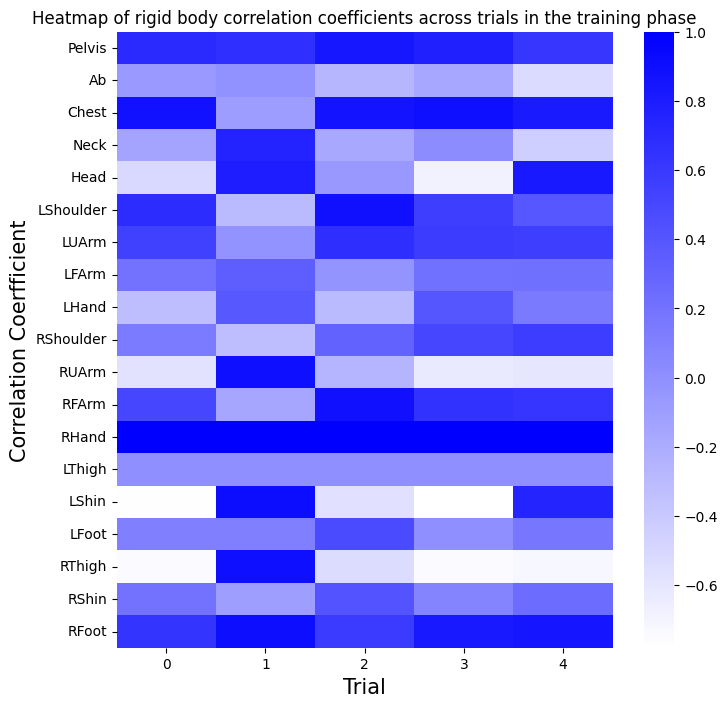

In [4]:
# Set parameters
trials = 5
rigidBodies = 19



# Pass the correct trial to the timestamp vector in seconds
timeStampVector =  timeStamps1  / 1000 #

correlationCoefficientsAcrossTrials = np.zeros((rigidBodies,trials))

# Analyse biggest PC of each rigid body trial 1 (training)
outputDictPCAVectorsTrial1 = extractPCAFromRigidBodies(rigidBodies1,cursorPos1)

# Analyse biggest PC of each rigid body trial 2 (training)
outputDictPCAVectorsTrial2 = extractPCAFromRigidBodies(rigidBodies2,cursorPos2)

# Analyse biggest PC of each rigid body trial 3 (training)
outputDictPCAVectorsTrial3 = extractPCAFromRigidBodies(rigidBodies3,cursorPos3)

# Analyse biggest PC of each rigid body trial 4 (training)
outputDictPCAVectorsTrial4 = extractPCAFromRigidBodies(rigidBodies4,cursorPos4)

# Analyse biggest PC of each rigid body trial 5 (test)
outputDictPCAVectorsTrial5 = extractPCAFromRigidBodies(rigidBodies5,cursorPos5)

# Collate all correlation coefficients to measure the evolution
correlationCoefficientsAcrossTrials[:,0] = outputDictPCAVectorsTrial1['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,1] = outputDictPCAVectorsTrial2['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,2] = outputDictPCAVectorsTrial3['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,3] = outputDictPCAVectorsTrial4['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,4] = outputDictPCAVectorsTrial5['rigidBodiesCorrCoeffs']

# # Plot rigid body correlation coefficients
# plt.plot(correlationCoefficientsAcrossTrials.transpose())
# plt.show()

# plt.imshow(correlationCoefficientsAcrossTrials, interpolation='nearest')
# plt.colorbar()  # To show the scale
# plt.show()

import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap

# Define the colors
colors = ["#ffffff","#0000ff"]  # Blue to white to red

# Create the colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors )
plt.figure(figsize=(8, 8)) 
sns.heatmap(correlationCoefficientsAcrossTrials, cmap = cmap, yticklabels = bodyParts)

plt.title("Heatmap of rigid body correlation coefficients across trials in the training phase")
plt.xlabel("Trial", fontsize = 15)
plt.ylabel("Correlation Coerfficient", fontsize = 15)
plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")

Rigid Body: Pelvis, variance explained in PC1: 0.9320808112845366, and in PC2: 0.043723477929099946
Rigid Body: Ab, variance explained in PC1: 0.80642172755598, and in PC2: 0.10664935266122803
Rigid Body: Chest, variance explained in PC1: 0.8696503471470367, and in PC2: 0.0891537126105077
Rigid Body: Neck, variance explained in PC1: 0.916480510151876, and in PC2: 0.04748437481816797
Rigid Body: Head, variance explained in PC1: 0.5652004829299686, and in PC2: 0.2724771265442647
Rigid Body: LShoulder, variance explained in PC1: 0.8473539798398839, and in PC2: 0.1159573963706184
Rigid Body: LUArm, variance explained in PC1: 0.9180296809740405, and in PC2: 0.04825652432981799
Rigid Body: LFArm, variance explained in PC1: 0.8113702451572773, and in PC2: 0.10939169080823069
Rigid Body: LHand, variance explained in PC1: 0.7865285195174561, and in PC2: 0.1388192305623551
Rigid Body: RShoulder, variance explained in PC1: 0.7539030181353763, and in PC2: 0.18362736275712604
Rigid Body: RUArm, var

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_65065/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_65065/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_65065/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial "

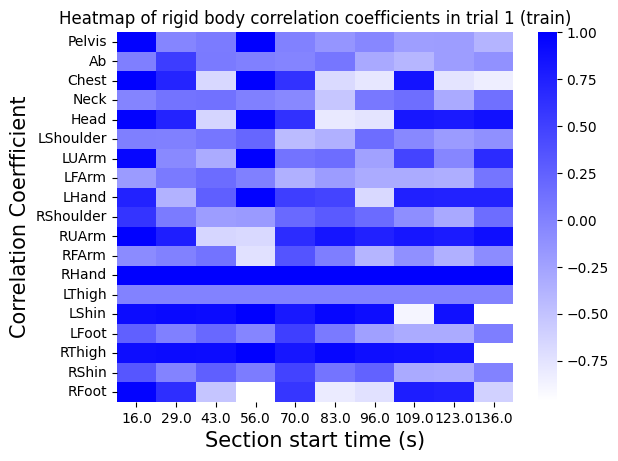

Rigid Body: Pelvis, variance explained in PC1: 0.9070733300916665, and in PC2: 0.06890035379610183
Rigid Body: Ab, variance explained in PC1: 0.5386877626758731, and in PC2: 0.3244481511116745
Rigid Body: Chest, variance explained in PC1: 0.7782919611048988, and in PC2: 0.17664812228094773
Rigid Body: Neck, variance explained in PC1: 0.7377380134052927, and in PC2: 0.23135645049700254
Rigid Body: Head, variance explained in PC1: 0.72389467259313, and in PC2: 0.24138650760404162
Rigid Body: LShoulder, variance explained in PC1: 0.8073921792770449, and in PC2: 0.1344818273772418
Rigid Body: LUArm, variance explained in PC1: 0.9081482122155952, and in PC2: 0.07347631287202297
Rigid Body: LFArm, variance explained in PC1: 0.9397536610270207, and in PC2: 0.0363066839867226
Rigid Body: LHand, variance explained in PC1: 0.9059792959826393, and in PC2: 0.0707980155943391
Rigid Body: RShoulder, variance explained in PC1: 0.7023977942164796, and in PC2: 0.1662783375827555
Rigid Body: RUArm, vari

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_65065/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_65065/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_65065/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial "

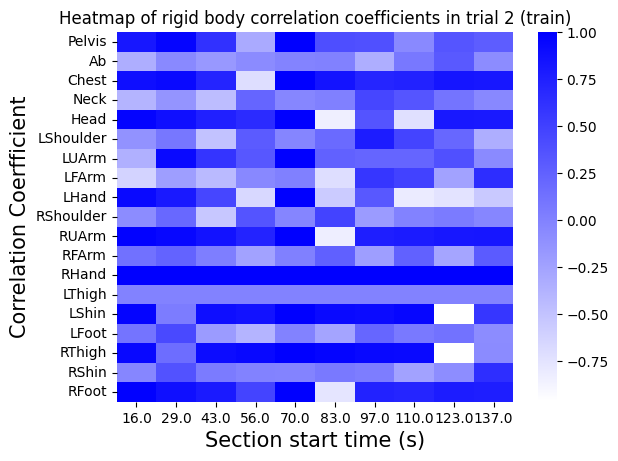

Rigid Body: Pelvis, variance explained in PC1: 0.8742486634936157, and in PC2: 0.04995296386591283
Rigid Body: Ab, variance explained in PC1: 0.7625738969307752, and in PC2: 0.15084069129882796
Rigid Body: Chest, variance explained in PC1: 0.815477354064244, and in PC2: 0.08998112753082427
Rigid Body: Neck, variance explained in PC1: 0.7925407035087115, and in PC2: 0.11152545305816859
Rigid Body: Head, variance explained in PC1: 0.6826851540517597, and in PC2: 0.21008422814746244
Rigid Body: LShoulder, variance explained in PC1: 0.8151057201483369, and in PC2: 0.12916020032087103
Rigid Body: LUArm, variance explained in PC1: 0.8134215444900506, and in PC2: 0.07069031856645978
Rigid Body: LFArm, variance explained in PC1: 0.5718052926953396, and in PC2: 0.20963380723887692
Rigid Body: LHand, variance explained in PC1: 0.5537126312656405, and in PC2: 0.21053926829592082
Rigid Body: RShoulder, variance explained in PC1: 0.6620698874120009, and in PC2: 0.24847195501355407
Rigid Body: RUArm

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_65065/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_65065/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_65065/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial "

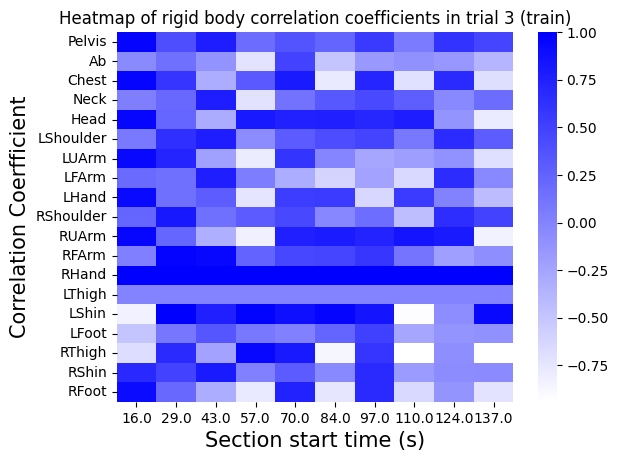

Rigid Body: Pelvis, variance explained in PC1: 0.8185886518273666, and in PC2: 0.10692771322791295
Rigid Body: Ab, variance explained in PC1: 0.7895842473301694, and in PC2: 0.09306896498379946
Rigid Body: Chest, variance explained in PC1: 0.8425691393555736, and in PC2: 0.08449408281056665
Rigid Body: Neck, variance explained in PC1: 0.7422600989461127, and in PC2: 0.13650739229397205
Rigid Body: Head, variance explained in PC1: 0.5484482442880387, and in PC2: 0.30583927487194645
Rigid Body: LShoulder, variance explained in PC1: 0.7844475767886907, and in PC2: 0.12665058148492578
Rigid Body: LUArm, variance explained in PC1: 0.8845782045579729, and in PC2: 0.054581139144892266
Rigid Body: LFArm, variance explained in PC1: 0.726610628629775, and in PC2: 0.1716012633422452
Rigid Body: LHand, variance explained in PC1: 0.6715146426640659, and in PC2: 0.19886839438518403
Rigid Body: RShoulder, variance explained in PC1: 0.7856170671421008, and in PC2: 0.12395155676143248
Rigid Body: RUArm

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_65065/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_65065/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_65065/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial "

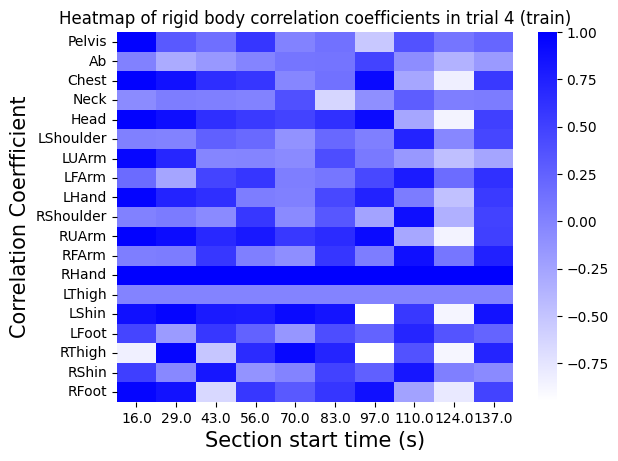

Rigid Body: Pelvis, variance explained in PC1: 0.8716928130697329, and in PC2: 0.06909434719445699
Rigid Body: Ab, variance explained in PC1: 0.7926955872603895, and in PC2: 0.10404471117733043
Rigid Body: Chest, variance explained in PC1: 0.833697588561765, and in PC2: 0.09023186779880166
Rigid Body: Neck, variance explained in PC1: 0.7685380047303381, and in PC2: 0.12075918319600713
Rigid Body: Head, variance explained in PC1: 0.7282280072238994, and in PC2: 0.1446755195479721
Rigid Body: LShoulder, variance explained in PC1: 0.8129371065796622, and in PC2: 0.10253340973619099
Rigid Body: LUArm, variance explained in PC1: 0.898917874532644, and in PC2: 0.04745596226108203
Rigid Body: LFArm, variance explained in PC1: 0.7632375083698585, and in PC2: 0.12270743187919796
Rigid Body: LHand, variance explained in PC1: 0.8029333249013266, and in PC2: 0.11172447256069538
Rigid Body: RShoulder, variance explained in PC1: 0.8219914203461038, and in PC2: 0.11439660733355901
Rigid Body: RUArm, 

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_65065/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_65065/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial " + trial)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_65065/2092727537.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trial "

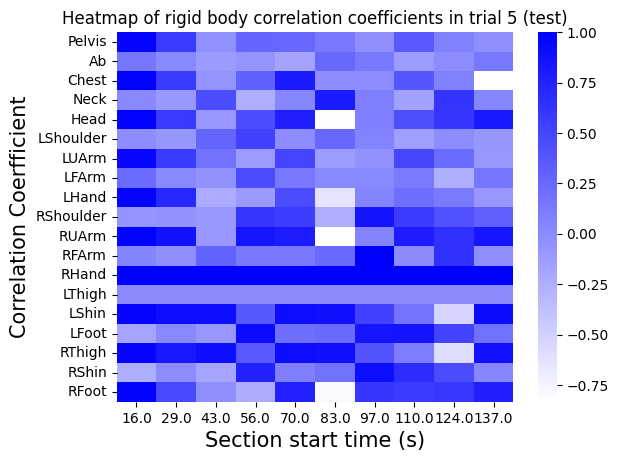

In [5]:
# Plot the correlation over a trial

plotCorrelationCoefficientVariationAcrossTrial(rigidBodies1,cursorPos1,trial = "1 (train)")
plt.show()
plotCorrelationCoefficientVariationAcrossTrial(rigidBodies2,cursorPos2,trial = "2 (train)")
plt.show()
plotCorrelationCoefficientVariationAcrossTrial(rigidBodies3,cursorPos3,trial = "3 (train)")
plt.show()
plotCorrelationCoefficientVariationAcrossTrial(rigidBodies4,cursorPos4,trial = "4 (train)")
plt.show()
plotCorrelationCoefficientVariationAcrossTrial(rigidBodies5,cursorPos5,trial = "5 (test)")
plt.show()

In [6]:
# Now look at learning over the decoder period



rigidBodiesE, cursorPosE,cursorVelE,goCuesE,targetHitsE,timeStampsE, minDofE,maxDofE,e = processTrialData(saveGameLocation + "_usingDecoderE",DOFOffset)
rigidBodiesF, cursorPosF,cursorVelF,goCuesF,targetHitsF,timeStampsF, minDofF,maxDofF,f = processTrialData(saveGameLocation + "_usingDecoderF",DOFOffset)
rigidBodiesG, cursorPosG,cursorVelG,goCuesG,targetHitsG,timeStampsG, minDofG,maxDofG,g = processTrialData(saveGameLocation + "_usingDecoderG",DOFOffset)
rigidBodiesH, cursorPosH,cursorVelH,goCuesH,targetHitsH,timeStampsH, minDofH,maxDofH,h = processTrialData(saveGameLocation + "_usingDecoderH",DOFOffset)
rigidBodiesI, cursorPosI,cursorVelI,goCuesI,targetHitsI,timeStampsI, minDofI,maxDofI,i = processTrialData(saveGameLocation + "_usingDecoderI",DOFOffset)
rigidBodiesJ, cursorPosJ,cursorVelJ,goCuesJ,targetHitsJ,timeStampsJ, minDofJ,maxDofJ,j = processTrialData(saveGameLocation + "_usingDecoderJ",DOFOffset)

Rigid Body: Pelvis, variance explained in PC1: 0.514835637382289, and in PC2: 0.23406734935204254
Rigid Body: Ab, variance explained in PC1: 0.5468666388693606, and in PC2: 0.22474069353179854
Rigid Body: Chest, variance explained in PC1: 0.5600663015357419, and in PC2: 0.27259084610091766
Rigid Body: Neck, variance explained in PC1: 0.6596942424725263, and in PC2: 0.16633974377257785
Rigid Body: Head, variance explained in PC1: 0.6304323575419729, and in PC2: 0.229000954744914
Rigid Body: LShoulder, variance explained in PC1: 0.6327366800469293, and in PC2: 0.2181955501422616
Rigid Body: LUArm, variance explained in PC1: 0.5027195461593668, and in PC2: 0.25643792357733514
Rigid Body: LFArm, variance explained in PC1: 0.4085996770703031, and in PC2: 0.30190492811940245
Rigid Body: LHand, variance explained in PC1: 0.4109441946182369, and in PC2: 0.3345160517971707
Rigid Body: RShoulder, variance explained in PC1: 0.60160175072231, and in PC2: 0.2383155954612804
Rigid Body: RUArm, varia

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_65065/4068059672.py:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_65065/4068059672.py:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_65065/4068059672.py:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingP

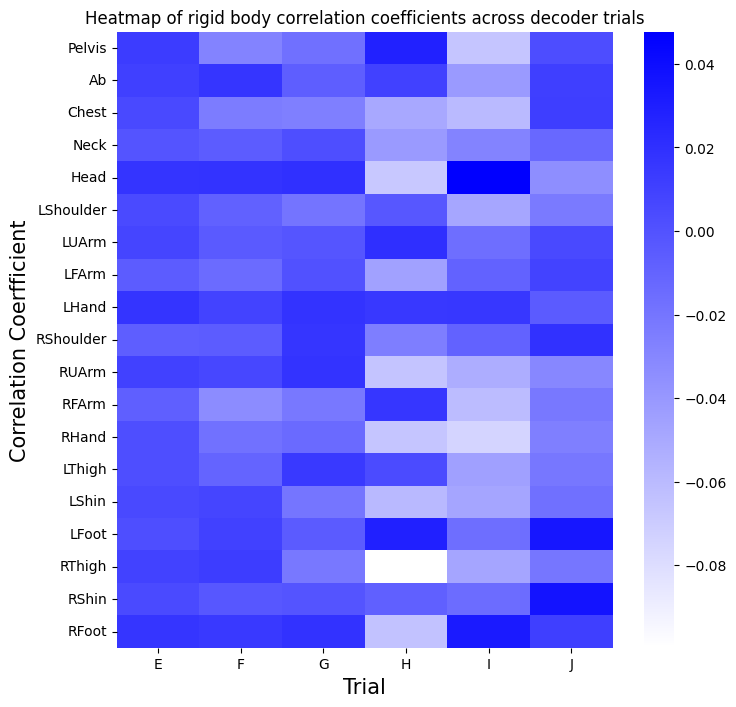

In [7]:
# Set parameters
trials = 6
rigidBodies = 19



# Pass the correct trial to the timestamp vector in seconds
timeStampVector =  timeStamps1  / 1000 #

correlationCoefficientsAcrossTrials = np.zeros((rigidBodies,trials))

# Analyse biggest PC of each rigid body trial E
outputDictPCAVectorsTrialE = extractPCAFromRigidBodies(rigidBodiesE,cursorPosE,useCursor = True)

# Analyse biggest PC of each rigid body trial F
outputDictPCAVectorsTrialF = extractPCAFromRigidBodies(rigidBodiesF,cursorPosF,useCursor = True)

# Analyse biggest PC of each rigid body trial G
outputDictPCAVectorsTrialG = extractPCAFromRigidBodies(rigidBodiesG,cursorPosG,useCursor = True)

# Analyse biggest PC of each rigid body trial H
outputDictPCAVectorsTrialH = extractPCAFromRigidBodies(rigidBodiesH,cursorPosH,useCursor = True)

# Analyse biggest PC of each rigid body trial I
outputDictPCAVectorsTrialI = extractPCAFromRigidBodies(rigidBodiesI,cursorPosI,useCursor = True)

# Analyse biggest PC of each rigid body trial J 
outputDictPCAVectorsTrialJ = extractPCAFromRigidBodies(rigidBodiesJ,cursorPosJ,useCursor = True)

# Collate all correlation coefficients to measure the evolution
correlationCoefficientsAcrossTrials[:,0] = outputDictPCAVectorsTrialE['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,1] = outputDictPCAVectorsTrialF['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,2] = outputDictPCAVectorsTrialG['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,3] = outputDictPCAVectorsTrialH['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,4] = outputDictPCAVectorsTrialI['rigidBodiesCorrCoeffs']
correlationCoefficientsAcrossTrials[:,5] = outputDictPCAVectorsTrialJ['rigidBodiesCorrCoeffs']

# # Plot rigid body correlation coefficients
# plt.plot(correlationCoefficientsAcrossTrials.transpose())
# plt.show()

# plt.imshow(correlationCoefficientsAcrossTrials, interpolation='nearest')
# plt.colorbar()  # To show the scale
# plt.show()

import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap

# Define the colors
colors = ["#ffffff","#0000ff"]  # Blue to white to red
decoders = ['E','F','G','H','I','J']
# Create the colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors )
plt.figure(figsize=(8, 8)) 
sns.heatmap(correlationCoefficientsAcrossTrials, cmap = cmap, yticklabels = bodyParts, xticklabels=decoders)

plt.title("Heatmap of rigid body correlation coefficients across decoder trials")
plt.xlabel("Trial", fontsize = 15)
plt.ylabel("Correlation Coerfficient", fontsize = 15)
plt.savefig(saveGameLocation + "_rigidBodyCorrelationHeatmap_trainingPhase")